# Artificial Neural Networks Final Project

In [1]:
# Libraries
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import cv2
from PIL import Image
from datetime import datetime
import pandas as pd

# Import custom dataset utilities
from detection_utils import CattleDatasetLoader


In [2]:
# Create output directories
os.makedirs("outputs/models", exist_ok=True)
os.makedirs("outputs/results", exist_ok=True)


In [3]:
#Configuration

# Classes (3 body parts)
CLASSES = {0: "Head", 1: "Leg", 2: "Back"}
NUM_CLASSES = 3

# Image settings
IMAGE_SIZE = 256
BATCH_SIZE = 4

# Dataset split
TRAIN_RATIO = 0.8       
VAL_RATIO = 0.1         
TEST_RATIO = 0.1

# Training settings
EPOCHS = 100        
DROPOUT_RATE = 0.3      

# Optimizer settings
OPTIMIZER = "adam"      
LEARNING_RATE = 1e-3    
LR_DECAY = "cosine"     

# Fixed values
MAX_DETECTIONS = 6      
BBOX_DIM = 4           
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


print(f"  Epochs: {EPOCHS} - Batch: {BATCH_SIZE} - Image: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"  Split: {TRAIN_RATIO*100:.0f}%/{VAL_RATIO*100:.0f}%/{TEST_RATIO*100:.0f}%")

  Epochs: 100 - Batch: 4 - Image: 256x256
  Split: 80%/10%/10%


In [4]:
# Initialize dataset loader
loader = CattleDatasetLoader(
    annotations_dir="annotations",
    images_dir="images",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

# Get train, validation, and test datasets
train_ds, val_ds, test_ds = loader.create_dataset_triple_split(
    train_ratio=TRAIN_RATIO,
    val_ratio=VAL_RATIO,
    test_ratio=TEST_RATIO
)

print(f"\nDataset loaded successfully!")
print(f"Train batches: {len(list(train_ds))}")
print(f"Validation batches: {len(list(val_ds))}")
print(f"Test batches: {len(list(test_ds))}")

Dataset split complete:
  Train: 342 images (79.9%)
  Val: 42 images (9.8%)
  Test: 44 images (10.3%)

Dataset loaded successfully!
Train batches: 86
Validation batches: 11
Test batches: 11


In [5]:
# Data augmentation function
def augment_data(image, bbox, cls):

    # Random brightness
    image = tf.image.random_brightness(image, max_delta=0.2)
    
    # Random contrast
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    
    # Random saturation
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    
    # Random horizontal flip (with bbox adjustment)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        # Flip bounding box x-coordinates
        x_min = bbox[:, 0]
        x_max = bbox[:, 2]
        bbox = tf.stack([1.0 - x_max, bbox[:, 1], 1.0 - x_min, bbox[:, 3]], axis=1)
    
    # Clip values to valid range
    image = tf.clip_by_value(image, 0.0, 1.0)
    
    return image, {"bbox_output": bbox, "cls_output": cls}

# Apply augmentation to training dataset with repeat for multiple epochs
train_ds = train_ds.unbatch().map(
    lambda img, labels: augment_data(img, labels["bbox_output"], labels["cls_output"]),
    num_parallel_calls=tf.data.AUTOTUNE
).batch(BATCH_SIZE).repeat().prefetch(tf.data.AUTOTUNE)

# Validation and test datasets repeat
val_ds = val_ds.repeat()
test_ds = test_ds.repeat()


In [6]:
def build_lightweight_cnn(input_shape=(256, 256, 3), dropout_rate=0.4):

    inputs = layers.Input(shape=input_shape, name="image_input")
    
    # Enhanced convolutional backbone (5 blocks with more filters)
    filters = [32, 64, 128, 256, 256]  # Increased capacity for better feature learning
    x = inputs
    
    for i, num_filters in enumerate(filters):
        # Double conv layers per block for better features
        x = layers.Conv2D(num_filters, (3, 3), padding="same", name=f"conv_{i+1}_1")(x)
        x = layers.BatchNormalization(name=f"bn_{i+1}_1")(x)
        x = layers.Activation("relu", name=f"relu_{i+1}_1")(x)
        x = layers.Conv2D(num_filters, (3, 3), padding="same", name=f"conv_{i+1}_2")(x)
        x = layers.BatchNormalization(name=f"bn_{i+1}_2")(x)
        x = layers.Activation("relu", name=f"relu_{i+1}_2")(x)
        x = layers.MaxPooling2D((2, 2), name=f"pool_{i+1}")(x)
    
    # Flatten and enhanced dense layers with dropout
    x = layers.Flatten(name="flatten")(x)
    x = layers.Dense(512, activation="relu", name="dense_1")(x)
    x = layers.Dropout(dropout_rate, name="dropout_1")(x)
    x = layers.Dense(256, activation="relu", name="dense_2")(x)
    x = layers.Dropout(dropout_rate, name="dropout_2")(x)
    x = layers.Dense(128, activation="relu", name="dense_3")(x)
    x = layers.Dropout(dropout_rate, name="dropout_3")(x)
    
    # Output head 1: Bounding box regression (6 detections × 4 coords)
    bbox_output = layers.Dense(MAX_DETECTIONS * BBOX_DIM, activation="sigmoid", name="bbox_raw")(x)
    bbox_output = layers.Reshape((MAX_DETECTIONS, BBOX_DIM), name="bbox_output")(bbox_output)
    
    # Output head 2: Classification (6 detections × 3 classes)
    cls_output = layers.Dense(MAX_DETECTIONS * NUM_CLASSES, activation="linear", name="cls_raw")(x)
    cls_output = layers.Reshape((MAX_DETECTIONS, NUM_CLASSES), name="cls_reshaped")(cls_output)
    cls_output = layers.Softmax(name="cls_output")(cls_output)
    
    # Build model
    model = models.Model(inputs=inputs, outputs=[bbox_output, cls_output], name="Cattle_Detection-CNN")
    
    return model

# Build the model
model = build_lightweight_cnn(dropout_rate=0.4)

# Display model architecture
model.summary()

Model: "Cattle_Detection-CNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_1_1 (Conv2D)   │ (None, 256, 256,  │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_1_1              │ (None, 256, 256,  │        128 │ conv_1_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu_1_1            │ (None, 256, 256,  │          0 │ bn_1_1[0][0]      │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_1_2 (Conv2D)   │ (None, 256, 256,  │      9,248 │ relu_1_1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_1_2              │ (None, 256, 256,  │        128 │ conv_1_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu_1_2            │ (None, 256, 256,  │          0 │ bn_1_2[0][0]      │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool_1              │ (None, 128, 128,  │          0 │ relu_1_2[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2_1 (Conv2D)   │ (None, 128, 128,  │     18,496 │ pool_1[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_2_1              │ (None, 128, 128,  │        256 │ conv_2_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu_2_1            │ (None, 128, 128,  │          0 │ bn_2_1[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2_2 (Conv2D)   │ (None, 128, 128,  │     36,928 │ relu_2_1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_2_2              │ (None, 128, 128,  │        256 │ conv_2_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu_2_2            │ (None, 128, 128,  │          0 │ bn_2_2[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool_2              │ (None, 64, 64,    │          0 │ relu_2_2[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_3_1 (Conv2D)   │ (None, 64, 64,    │     73,856 │ pool_2[0][0]      │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_3_1              │ (None, 64, 64,    │        512 │ conv_3_1[0][0]  

 Total params: 10,917,066 (41.65 MB)

 Trainable params: 10,914,122 (41.63 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [7]:
# Loss functions
bbox_loss = tf.keras.losses.MeanSquaredError(name="mse_loss")
cls_loss = tf.keras.losses.CategoricalCrossentropy(name="categorical_crossentropy")

# Combined loss weights
BBOX_LOSS_WEIGHT = 10.0
CLS_LOSS_WEIGHT = 1.0

In [8]:
#Optimizer function with learning rate decay
def create_optimizer(opt_name, learning_rate, decay_type, total_steps):

    # Create optimizer with optional learning rate decay
    if decay_type == "exponential":
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=learning_rate,
            decay_steps=total_steps // 10,
            decay_rate=0.9,
            staircase=True
        )
    elif decay_type == "cosine":
        lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
            initial_learning_rate=learning_rate,
            decay_steps=total_steps
        )
    else:
        lr_schedule = learning_rate
    
    if opt_name == "adam":
        return tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    elif opt_name == "rmsprop":
        return tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)
    else:
        return tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)


In [9]:
# Build model with configured dropout rate
model = build_lightweight_cnn(dropout_rate=DROPOUT_RATE)

# Calculate total training steps for LR scheduler
num_train_images = int(454 * TRAIN_RATIO)
steps_per_epoch = num_train_images // BATCH_SIZE + (1 if num_train_images % BATCH_SIZE else 0)
total_training_steps = steps_per_epoch * EPOCHS
print(f"Calculated steps_per_epoch: {steps_per_epoch}")

# Create optimizer
optimizer = create_optimizer(OPTIMIZER, LEARNING_RATE, LR_DECAY, total_training_steps)

# Compile model
model.compile(
    optimizer=optimizer,
    loss={
        "bbox_output": bbox_loss,
        "cls_output": cls_loss
    },
    loss_weights={
        "bbox_output": BBOX_LOSS_WEIGHT,
        "cls_output": CLS_LOSS_WEIGHT
    },
    metrics={
        "bbox_output": ["mae"],
        "cls_output": ["accuracy"]
    }
)

print("Model Architecture:")
print(f"  - Optimizer: {OPTIMIZER}")
print(f"  - LR: {LEARNING_RATE}")
print(f"  - Dropout: {DROPOUT_RATE}")
print(f"  - Epochs: {EPOCHS}")

Calculated steps_per_epoch: 91
Model Architecture:
  - Optimizer: adam
  - LR: 0.001
  - Dropout: 0.3
  - Epochs: 100


In [10]:
# Setup callbacks
checkpoint_path = "outputs/models/best_model.weights.h5"

callbacks = [
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min',
        verbose=1
    )
]

In [11]:
# Train the model

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=num_train_images // BATCH_SIZE // 10,
    callbacks=callbacks,
    verbose=1
)

print("=" * 60)
print("Training completed!")
print("=" * 60)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 998ms/step - bbox_output_loss: 0.2083 - bbox_output_mae: 0.4133 - cls_output_accuracy: 0.9341 - cls_output_loss: 0.3094 - loss: 2.3918
Epoch 1: val_loss improved from None to 1.96045, saving model to outputs/models/best_model.weights.h5
91/91 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - bbox_output_loss: 0.1792 - bbox_output_mae: 0.3725 - cls_output_accuracy: 0.9719 - cls_output_loss: 0.1909 - loss: 1.9803 - val_bbox_output_loss: 0.1960 - val_bbox_output_mae: 0.4140 - val_cls_output_accuracy: 0.9954 - val_cls_output_loss: 1.3797e-08 - val_loss: 1.9605
Epoch 2/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - bbox_output_loss: 0.1290 - bbox_output_mae: 0.2971 - cls_output_accuracy: 0.9896 - cls_output_loss: 0.1558 - loss: 1.4454
Epoch 2: val_loss improved from 1.96045 to 0.30498, saving model to outputs/models/best_model.weights.h5
91/91 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - bbox_output_loss: 0.1222 - bbox_output_mae: 0.2856 - cls_output_accuracy: 0.9908 - cls_ou

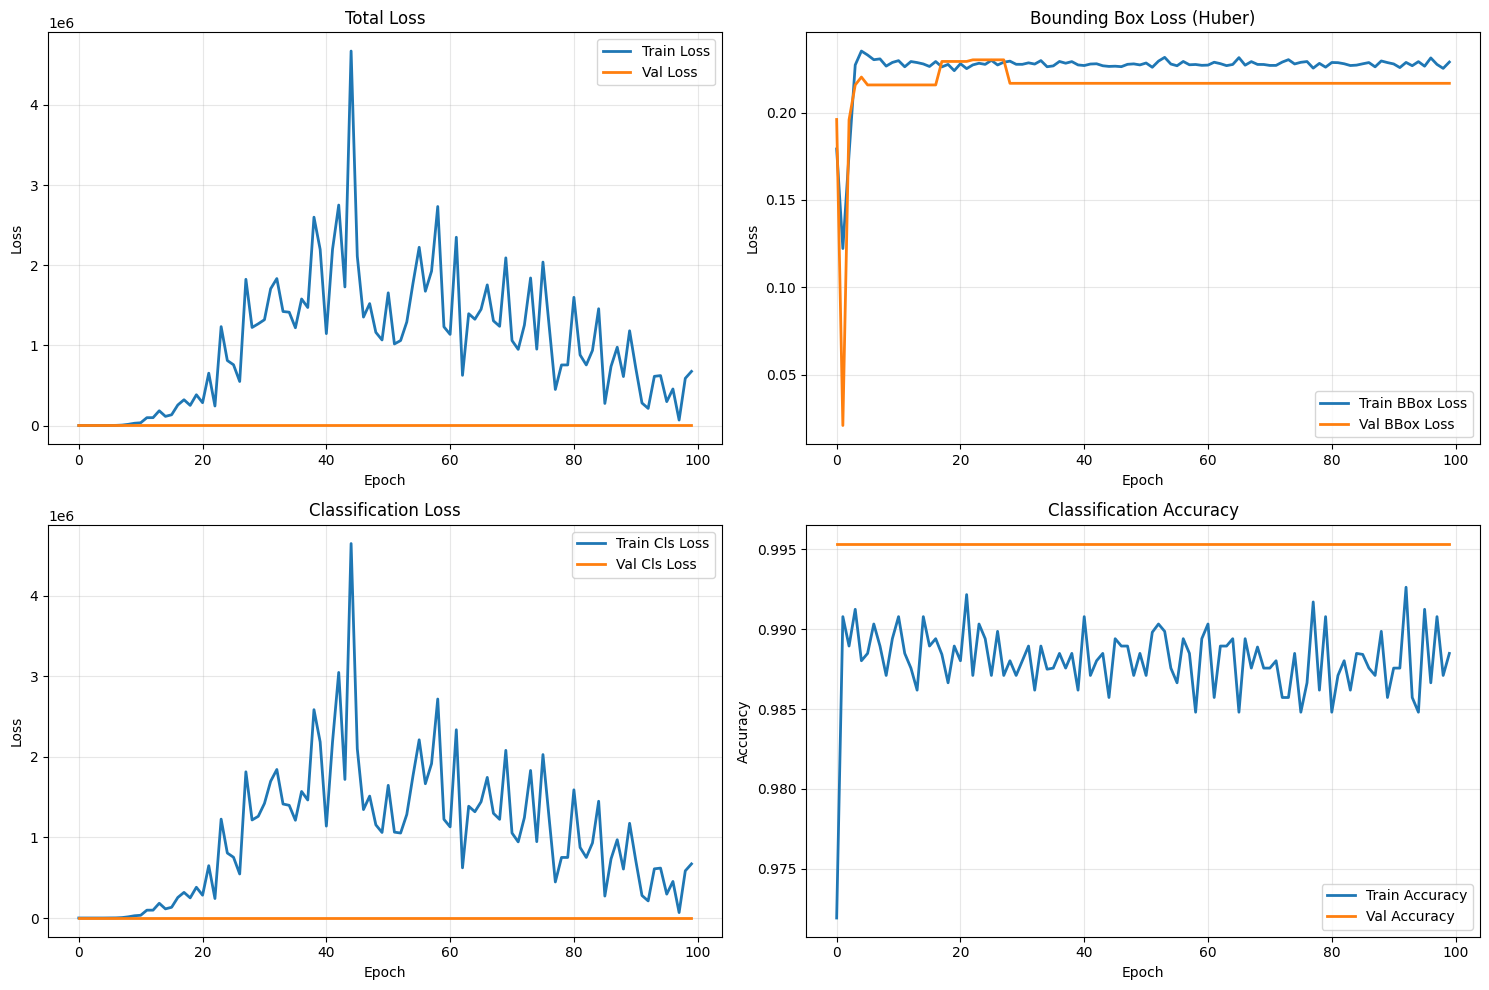

In [12]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Total loss
axes[0, 0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Total Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Bbox loss
axes[0, 1].plot(history.history['bbox_output_loss'], label='Train BBox Loss', linewidth=2)
axes[0, 1].plot(history.history['val_bbox_output_loss'], label='Val BBox Loss', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Bounding Box Loss (Huber)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Classification loss
axes[1, 0].plot(history.history['cls_output_loss'], label='Train Cls Loss', linewidth=2)
axes[1, 0].plot(history.history['val_cls_output_loss'], label='Val Cls Loss', linewidth=2)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('Classification Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Classification accuracy
axes[1, 1].plot(history.history['cls_output_accuracy'], label='Train Accuracy', linewidth=2)
axes[1, 1].plot(history.history['val_cls_output_accuracy'], label='Val Accuracy', linewidth=2)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_title('Classification Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/results/loss_curve.png', dpi=300, bbox_inches='tight')
plt.show()


In [13]:
# Load weights
model.load_weights(checkpoint_path)

# Evaluate on dataset
print("\nModel Evaluation")
num_test_images = int(454 * TEST_RATIO)
test_steps = num_test_images // BATCH_SIZE + (1 if num_test_images % BATCH_SIZE else 0)
test_results = model.evaluate(test_ds, steps=test_steps, verbose=1)

print("\nModel Results:")
print(f"  Total Loss: {test_results[0]:.4f}")
print(f"  BBox Loss: {test_results[1]:.4f}")
print(f"  Classification Loss: {test_results[2]:.4f}")
print(f"  BBox MAE: {test_results[3]:.4f}")
print(f"  Classification Accuracy: {test_results[4]:.4f}")


Model Evaluation
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 252ms/step - bbox_output_loss: 0.0255 - bbox_output_mae: 0.1082 - cls_output_accuracy: 0.9826 - cls_output_loss: 0.0913 - loss: 0.3467

Model Results:
  Total Loss: 0.3467
  BBox Loss: 0.0255
  Classification Loss: 0.0913
  BBox MAE: 0.1082
  Classification Accuracy: 0.9826


In [14]:
# Compute IoU and mAP using utilities from detection_utils
iou_values = []
all_predictions = []
all_ground_truth = []

for batch_idx, (images, labels) in enumerate(test_ds):
    if batch_idx >= test_steps:
        break
    # Unpack labels from dictionary
    bboxes_true = labels["bbox_output"]
    classes_true = labels["cls_output"]
    
    # Get predictions
    bboxes_pred, classes_pred = model.predict(images, verbose=0)
    
    # Calculate IoU for each sample
    for i in range(len(images)):
        for j in range(MAX_DETECTIONS):
            bbox_true = bboxes_true[i, j].numpy()
            bbox_pred = bboxes_pred[i, j]
            
            # Skip if ground truth bbox is empty (all zeros)
            if np.sum(bbox_true) > 0:
                iou = loader.compute_iou(bbox_pred, bbox_true)
                iou_values.append(iou)
    
    all_predictions.append((bboxes_pred, classes_pred))
    all_ground_truth.append((bboxes_true, classes_true))

# Calculate mean IoU
mean_iou = np.mean(iou_values) if iou_values else 0.0

print(f"\nMean IoU: {mean_iou:.4f}")
print(f"Number of valid detections: {len(iou_values)}")

# Save IoU values
iou_df = pd.DataFrame({'IoU': iou_values})
iou_df.to_csv('outputs/results/iou_values.csv', index=False)


Mean IoU: 0.1126
Number of valid detections: 283


In [15]:
# Calculate per-class Average Precision with debugging
# Try multiple IoU thresholds since model is undertrained
iou_thresholds = [0.5, 0.3, 0.1]
map_results = {}

for iou_threshold in iou_thresholds:
    class_aps = {}
    
    for class_id in range(NUM_CLASSES):
        true_positives = 0
        false_positives = 0
        false_negatives = 0
        total_gt = 0
        total_pred = 0
        
        for (bboxes_true, classes_true), (bboxes_pred, classes_pred) in zip(all_ground_truth, all_predictions):
            for i in range(len(bboxes_true)):
                # Track which ground truth boxes have been matched
                matched_gt = set()
                
                for j in range(MAX_DETECTIONS):
                    # Check if this is a valid ground truth
                    gt_class = np.argmax(classes_true[i, j])
                    bbox_true = bboxes_true[i, j]
                    
                    if gt_class == class_id and np.sum(bbox_true) > 0:
                        total_gt += 1
                    
                    # Check predictions
                    pred_class = np.argmax(classes_pred[i, j])
                    bbox_pred = bboxes_pred[i, j]
                    confidence = classes_pred[i, j][pred_class]
                    
                    # Only consider predictions with reasonable confidence
                    if pred_class == class_id and confidence > 0.3:
                        total_pred += 1
                        
                        # Find best matching ground truth
                        best_iou = 0
                        best_gt_idx = -1
                        
                        for k in range(MAX_DETECTIONS):
                            gt_class_k = np.argmax(classes_true[i, k])
                            bbox_true_k = bboxes_true[i, k]
                            
                            if gt_class_k == class_id and np.sum(bbox_true_k) > 0 and k not in matched_gt:
                                iou = loader.compute_iou(bbox_pred, bbox_true_k.numpy())
                                if iou > best_iou:
                                    best_iou = iou
                                    best_gt_idx = k
                        
                        # Check if this is a true positive
                        if best_iou >= iou_threshold and best_gt_idx >= 0:
                            true_positives += 1
                            matched_gt.add(best_gt_idx)
                        else:
                            false_positives += 1
                
                # Count unmatched ground truth boxes as false negatives
                for j in range(MAX_DETECTIONS):
                    gt_class = np.argmax(classes_true[i, j])
                    if gt_class == class_id and np.sum(bboxes_true[i, j]) > 0 and j not in matched_gt:
                        false_negatives += 1
        
        # Calculate AP
        if total_gt > 0:
            precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
            recall = true_positives / total_gt if total_gt > 0 else 0
            ap = precision  # Simplified AP calculation
            class_aps[CLASSES[class_id]] = ap
            
            if iou_threshold == 0.5:  # Only print details for standard threshold
                print(f"\n{CLASSES[class_id]} stats (@IoU=0.5):")
                print(f"  GT: {total_gt}, Pred: {total_pred}, TP: {true_positives}, FP: {false_positives}, FN: {false_negatives}")
                print(f"  Precision: {precision:.4f}, Recall: {recall:.4f}, AP: {ap:.4f}")
        else:
            class_aps[CLASSES[class_id]] = 0.0
            if iou_threshold == 0.5:
                print(f"\n{CLASSES[class_id]} stats: No ground truth instances found")
    
    # Calculate mAP for this threshold
    map_results[iou_threshold] = (np.mean(list(class_aps.values())), class_aps)

# Use 0.5 as primary metric
mAP = map_results[0.5][0]
class_aps = map_results[0.5][1]

print("\nPer-class Average Precision (@IoU=0.5):")
for class_name, ap in class_aps.items():
    print(f"  {class_name}: {ap:.4f}")

print(f"\nmAP@0.5: {mAP:.4f}")

# Show results at other thresholds for comparison
print("\nComparison at different IoU thresholds:")
for threshold in iou_thresholds:
    map_val, _ = map_results[threshold]
    print(f"  mAP@{threshold}: {map_val:.4f}")

# Save mAP summary
with open('outputs/results/map_summary.txt', 'w') as f:
    f.write("Mean Average Precision Summary\n")
    f.write("=" * 50 + "\n\n")
    f.write(f"mAP@0.5: {mAP:.4f}\n")
    f.write(f"Mean IoU: {mean_iou:.4f}\n\n")
    f.write("Per-class Average Precision (@IoU=0.5):\n")
    for class_name, ap in class_aps.items():
        f.write(f"  {class_name}: {ap:.4f}\n")
    f.write("\nComparison at different IoU thresholds:\n")
    for threshold in iou_thresholds:
        map_val, _ = map_results[threshold]
        f.write(f"  mAP@{threshold}: {map_val:.4f}\n")



Head stats (@IoU=0.5):
  GT: 48, Pred: 48, TP: 0, FP: 48, FN: 48
  Precision: 0.0000, Recall: 0.0000, AP: 0.0000

Leg stats (@IoU=0.5):
  GT: 187, Pred: 192, TP: 6, FP: 186, FN: 181
  Precision: 0.0312, Recall: 0.0321, AP: 0.0312

Back stats (@IoU=0.5):
  GT: 48, Pred: 48, TP: 17, FP: 31, FN: 31
  Precision: 0.3542, Recall: 0.3542, AP: 0.3542

Per-class Average Precision (@IoU=0.5):
  Head: 0.0000
  Leg: 0.0312
  Back: 0.3542

mAP@0.5: 0.1285

Comparison at different IoU thresholds:
  mAP@0.5: 0.1285
  mAP@0.3: 0.3142
  mAP@0.1: 0.4514


In [16]:
def denormalize_bbox(bbox, img_width, img_height):
    x_min, y_min, x_max, y_max = bbox
    return [
        int(x_min * img_width),
        int(y_min * img_height),
        int(x_max * img_width),
        int(y_max * img_height)
    ]

def draw_predictions(image, bboxes, classes, threshold=0.3):
    # Convert to uint8
    img_display = (image * 255).astype(np.uint8).copy()
    img_height, img_width = img_display.shape[:2]
    
    # Color map (matching detection_utils)
    colors = {
        0: (0, 255, 0),    # Head - Green
        1: (255, 0, 0),    # Leg - Blue (BGR format)
        2: (0, 165, 255)   # Back - Orange (BGR format)
    }
    
    for i in range(len(bboxes)):
        class_probs = classes[i]
        class_id = np.argmax(class_probs)
        confidence = class_probs[class_id]
        
        # Skip low confidence or empty detections
        if confidence < threshold or np.sum(bboxes[i]) == 0:
            continue
        
        # Denormalize bbox
        x_min, y_min, x_max, y_max = denormalize_bbox(bboxes[i], img_width, img_height)
        
        # Draw rectangle
        color = colors[class_id]
        cv2.rectangle(img_display, (x_min, y_min), (x_max, y_max), color, 2)
        
        # Draw label
        label = f"{CLASSES[class_id]} {confidence:.2f}"
        label_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        cv2.rectangle(img_display, (x_min, y_min - label_size[1] - 4), 
                     (x_min + label_size[0], y_min), color, -1)
        cv2.putText(img_display, label, (x_min, y_min - 2), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    
    return img_display

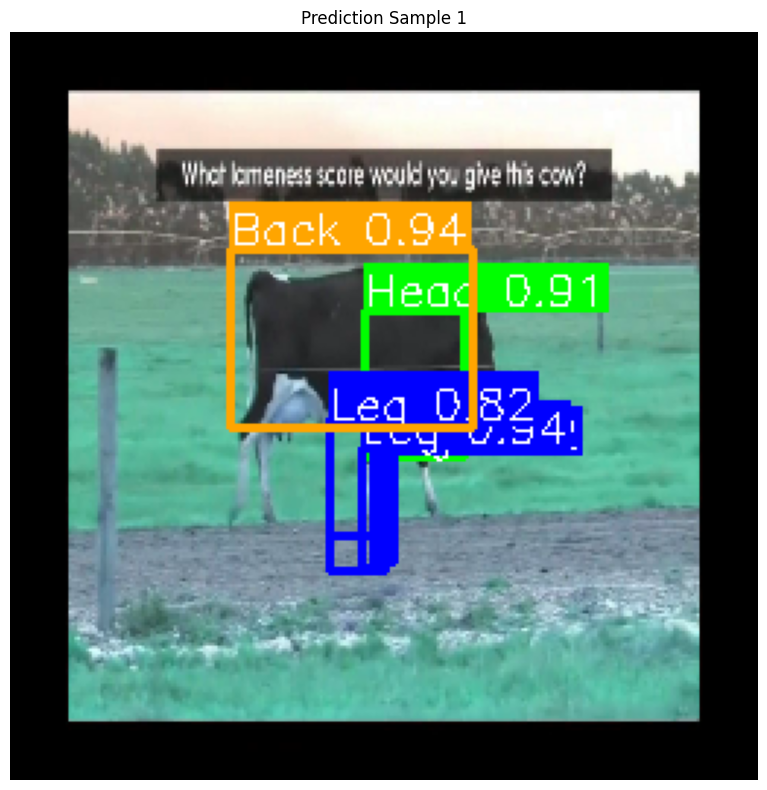

Sample 1 saved to outputs/results/predicted_cow_1.jpg


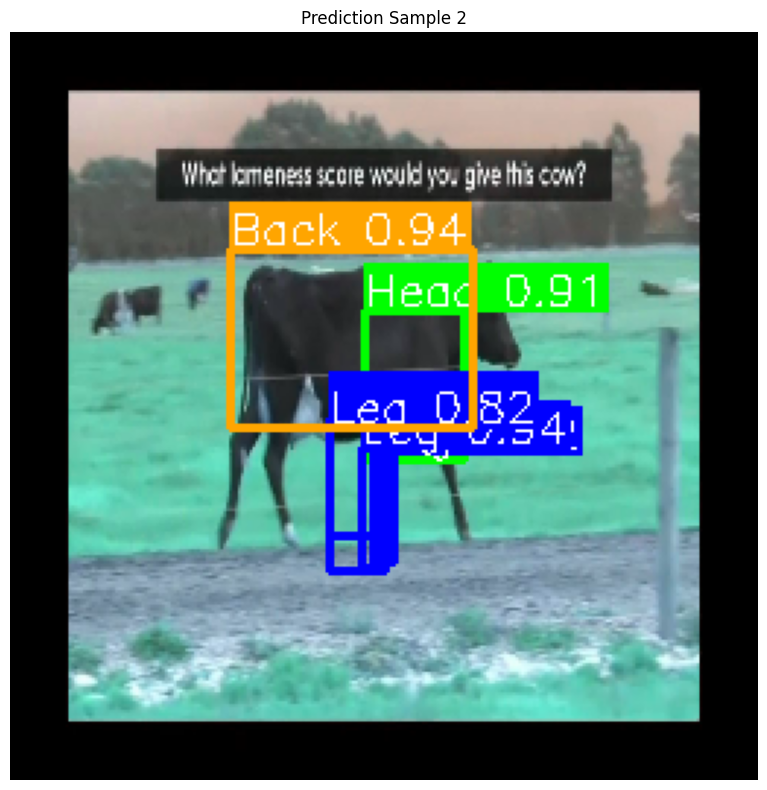

Sample 2 saved to outputs/results/predicted_cow_2.jpg


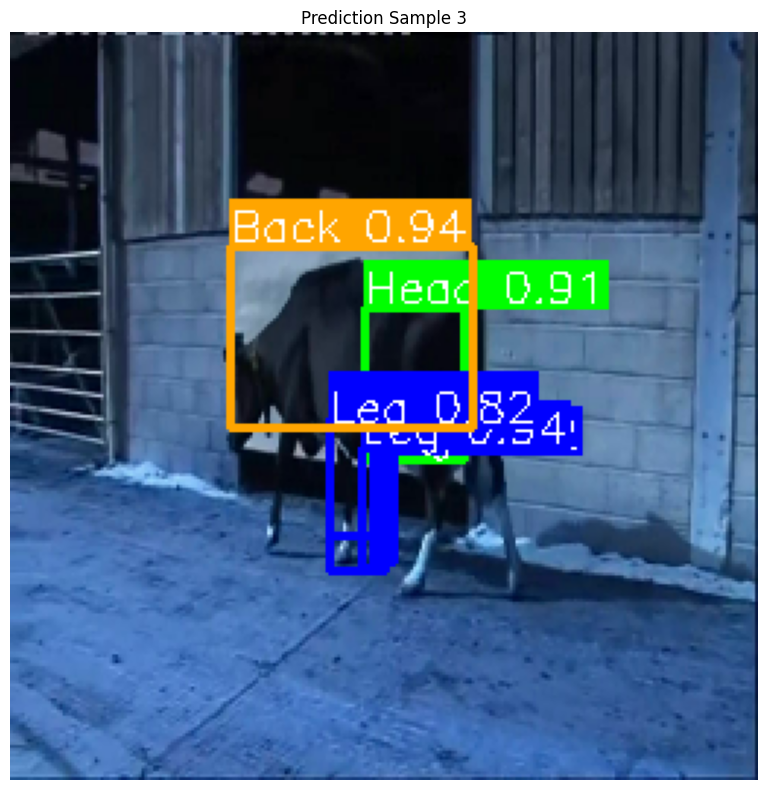

Sample 3 saved to outputs/results/predicted_cow_3.jpg


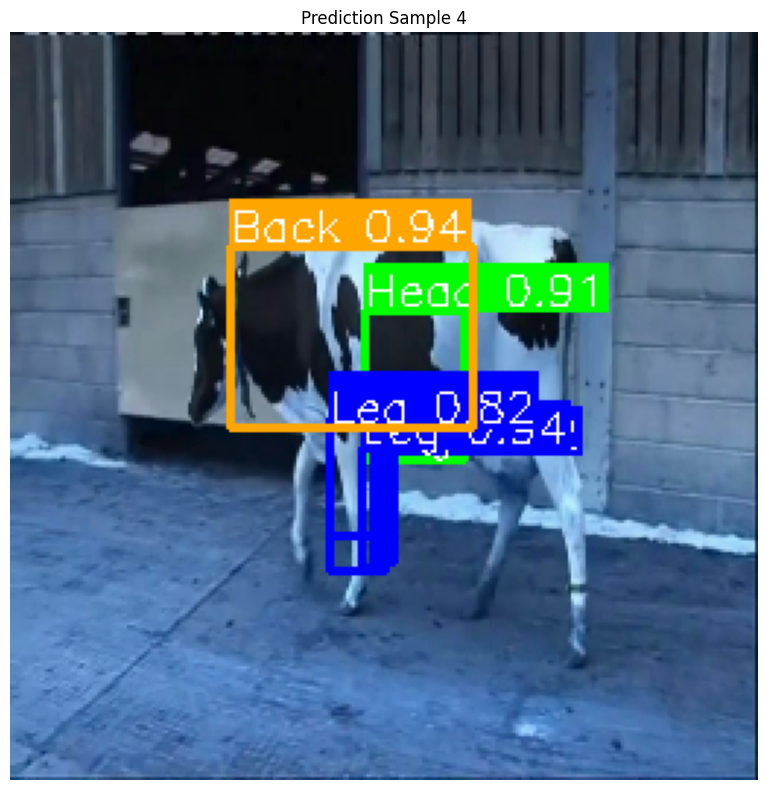

Sample 4 saved to outputs/results/predicted_cow_4.jpg


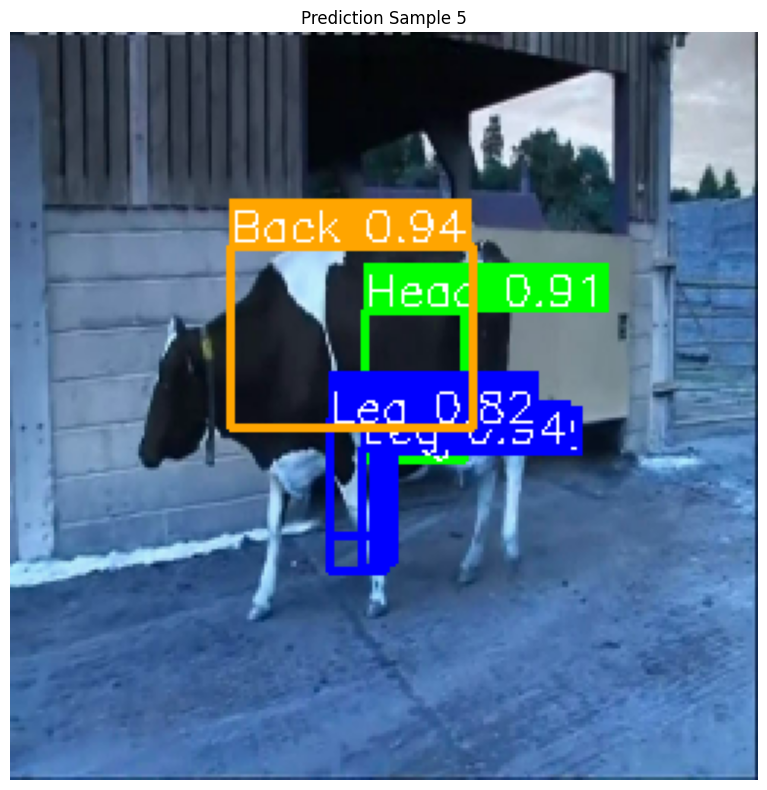

Sample 5 saved to outputs/results/predicted_cow_5.jpg


In [17]:
# Run inference on test set samples
num_samples = 5
sample_count = 0

for batch_idx, (images, labels) in enumerate(test_ds):
    if batch_idx >= test_steps:
        break
    if sample_count >= num_samples:
        break
    
    # Get predictions
    bboxes_pred, classes_pred = model.predict(images, verbose=0)
    
    for i in range(len(images)):
        if sample_count >= num_samples:
            break
        
        # Get single image
        img = images[i].numpy()
        
        # Draw predictions
        img_with_pred = draw_predictions(img, bboxes_pred[i], classes_pred[i], threshold=0.3)
        
        # Save result
        output_path = f"outputs/results/predicted_cow_{sample_count+1}.jpg"
        cv2.imwrite(output_path, img_with_pred)
        
        # Display
        plt.figure(figsize=(10, 8))
        plt.imshow(cv2.cvtColor(img_with_pred, cv2.COLOR_BGR2RGB))
        plt.title(f"Prediction Sample {sample_count+1}")
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        print(f"Sample {sample_count+1} saved to {output_path}")
        sample_count += 1

In [18]:
print("=" * 60)
print("MODEL SUMMARY")
print("=" * 60)

print("\nConfiguration:")
print(f"  - Images: 454 ({TRAIN_RATIO*100:.0f}%/{VAL_RATIO*100:.0f}%/{TEST_RATIO*100:.0f}% split)")
print(f"  - Image size: {IMAGE_SIZE}×{IMAGE_SIZE}")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - Epochs trained: {len(history.history['loss'])}/{EPOCHS}")
print(f"  - Dropout: {DROPOUT_RATE}")
print(f"  - Optimizer: {OPTIMIZER} (LR={LEARNING_RATE})")

print("\n Overall Results:")
print(f"  - Total Loss: {test_results[0]:.4f}")
print(f"  - BBox Loss: {test_results[1]:.4f}")
print(f"  - Classification Loss: {test_results[2]:.4f}")
print(f"  - Mean IoU: {mean_iou:.4f}")
print(f"  - mAP@0.5: {mAP:.4f}")
print(f"  - Accuracy: {test_results[4]:.4f}")

MODEL SUMMARY

Configuration:
  - Images: 454 (80%/10%/10% split)
  - Image size: 256×256
  - Batch size: 4
  - Epochs trained: 100/100
  - Dropout: 0.3
  - Optimizer: adam (LR=0.001)

 Overall Results:
  - Total Loss: 0.3467
  - BBox Loss: 0.0255
  - Classification Loss: 0.0913
  - Mean IoU: 0.1126
  - mAP@0.5: 0.1285
  - Accuracy: 0.9826
